# Notebook 2: Cleaning & EDA

This notebooks is a sequel to notebook 1. Data cleaning and exploratory data analysis will be done here.

## Imports

In [13]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re

#warnings
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'seaborn'

In [14]:
depression = pd.read_csv('./data/depression.csv')
forever_alone = pd.read_csv('./data/forever_alone.csv')

## Data Cleaning

In [10]:
depression.head()

subreddit                                           selftext  \
0  depression  I just don't know why it happens with me but I...   
1  depression  Why is it impossible to get help with a deathw...   
2  depression  Life is just not my thing i guess, sure some p...   
3  depression  i‚Äôm so sad.. i‚Äôm thinking of committing suicid...   
4  depression  \n\n I am so fucking ugly and disgusting. I ha...   

                                               title                author  
0                        Extreme overthinking issues   No-Cryptographer-68  
1                               Why is there no help      Delicious_Sponge  
2  I wish I had managed to kill myself the first ...     YourLittleMonster  
3                                                  -  TargetResponsible719  
4                                           Honestly            Tacowh0ree

In [11]:
forever_alone.head()

subreddit                                           selftext  \
0  ForeverAlone  Hello üëãüèª I'm 24yo student from Croatia. I stud...   
1  ForeverAlone  It feels so difficult for me - I overthink eve...   
2  ForeverAlone  I'm just gonna go and light myself a cig in th...   
3  ForeverAlone  Sometimes feel like I have failed in life. I a...   
4  ForeverAlone  Hello everyone\n\nI've been lurking here on an...   

                                               title            author  
0   24 [M4F] European student looking for chat buddy          Croat999  
1  I'm starting to feel like there's no point in ...    FlimsyWeek6131  
2  What's the point in trying to find a relations...  LetterCrafty8735  
3                                  Failed and alone.     watch_more_tv  
4               a thought piece for the FA subreddit             SVice

#### Dropping Duplicates & Reset Index

In [5]:
depression.drop_duplicates(inplace=True)
depression.dropna(inplace = True)
print(depression.isnull().sum())

forever_alone.drop_duplicates(inplace=True)
forever_alone.dropna(inplace = True)
print(forever_alone.isnull().sum())

subreddit    0
selftext     0
title        0
author       0
dtype: int64
subreddit    0
selftext     0
title        0
author       0
dtype: int64


In [6]:
depression.reset_index(drop=True, inplace=True)
forever_alone.reset_index(drop=True, inplace=True)

In [7]:
# Changing columns to lower case
for columns in depression.columns:
    depression[columns] = depression[columns].str.lower() 
for columns in forever_alone.columns:
    forever_alone[columns] = forever_alone[columns].str.lower()

### Removing Common Titles between Both Datasets

In [8]:
dep_common_title = depression[depression['title'].isin(forever_alone['title']) == True]
fa_common_title = forever_alone[forever_alone['title'].isin(depression['title']) == True]

In [9]:
depression.drop(dep_common_title.index, inplace=True)
forever_alone.drop(fa_common_title.index, inplace=True)

In [10]:
depression.rename(columns={'selftext': 'text'}, inplace=True)
forever_alone.rename(columns={'selftext': 'text'}, inplace=True)

### Removing Special Characters

In [11]:
depression.head(2)

subreddit                                               text  \
0  depression  i just don't know why it happens with me but i...   
1  depression  why is it impossible to get help with a deathw...   

                         title               author  
0  extreme overthinking issues  no-cryptographer-68  
1         why is there no help     delicious_sponge

In [12]:
# for title
depression['title'] = depression['title'].apply(lambda x: re.sub('[^ a-zA-Z0-9]','', x).lower())
forever_alone['title'] = forever_alone['title'].apply(lambda x: re.sub('[^ a-zA-Z0-9]','', x).lower())

# for text
depression['text'] = depression['text'].apply(lambda x: re.sub('[^ a-zA-Z0-9]','', x).lower())
forever_alone['text'] = forever_alone['text'].apply(lambda x: re.sub('[^ a-zA-Z0-9]','', x).lower())

### Exploring the Distribution of Title and Text Words

#### Title Length

In [13]:
depression['text_length'] = depression['text'].map(len)
forever_alone['text_length'] = forever_alone['text'].map(len)

In [14]:
print(f"Mean Depression Post Text Length:", depression['text_length'].mean())
print(f"Mean Forever Alone Post Text Length:", forever_alone['text_length'].mean())

Mean Depression Post Text Length: 916.212232096184
Mean Forever Alone Post Text Length: 829.7726042230644


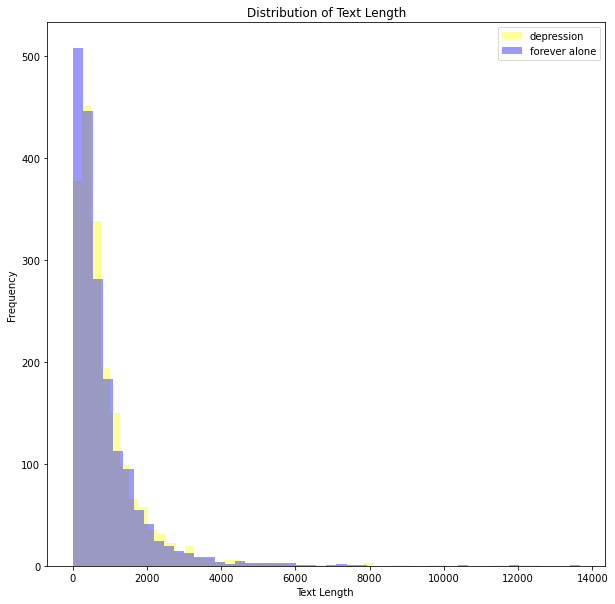

In [15]:
plt.figure(figsize=(10,10))
sns.distplot(depression['text_length'], kde=False, color='yellow', label='depression')
sns.distplot(forever_alone['text_length'], kde=False, color='blue', label='forever alone')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length ')
plt.ylabel('Frequency')
plt.legend()

#### Remove Outliers for Text Length

I will remove posts with abnormal text length of 1 or less

In [16]:
depression['text_length'].describe()

count     1913.000000
mean       916.212232
std       1122.108884
min          1.000000
25%        306.000000
50%        589.000000
75%       1134.000000
max      12622.000000
Name: text_length, dtype: float64

In [17]:
depression[depression['text_length'] <= 1]

subreddit text                                              title  \
475  depression       i dont know what im living for i get through t...   

           author  text_length  
475  alexamurillo            1

In [18]:
depression = depression.drop(labels = [475], axis=0)

In [19]:
depression[depression['text_length'] >= 10000]

subreddit                                               text  \
1014  depression  its painful anyway knowing you could be treate...   
1064  depression   hi im 20 m and just got into a lunch fight wi...   
1802  depression  i dont really know where to begin but here it ...   
1916  depression  ill try to be as brief as possible23 yo infp f...   

                                                  title         author  \
1014  dont read just wanted to put smwere cause fuck it  savekittycatt   
1064                       cant stand my father anymore      reddordit   
1802  i am kinda starting to lose hope for everythin...     thunder575   
1916                   i dont know where to drag myself     infp_grump   

      text_length  
1014        11986  
1064        12622  
1802        12283  
1916        11368

In [20]:
forever_alone[forever_alone['text_length'] <= 1]

subreddit text                                              title  \
1747  foreveralone    d  dont you love it when a girl makes lovey dovey...   

             author  text_length  
1747  oldmanrevived            1

In [21]:
forever_alone = forever_alone.drop(labels = [1747], axis=0)

In [22]:
forever_alone[forever_alone['text_length'] >= 10000]

subreddit                                               text  \
292   foreveralone  so people saypart one is some general thoughts...   
1479  foreveralone  ive been thinking today about loneliness solit...   
1814  foreveralone  please bare with me i have only really talked ...   

                                                  title               author  \
292                       sex overrated and unimportant   drinkingdamianatea   
1479  love dont mean nothing unless theres something...  garbagepailkid1980s   
1814          this is long but i have to vent somewhere             mokhalar   

      text_length  
292         11870  
1479        13667  
1814        10544

#### Word Counts

In [23]:
depression['word_count'] = depression['text'].map(lambda x: len(x.split()))
forever_alone['word_count'] = forever_alone['text'].map(lambda x: len(x.split()))

In [24]:
depression.sort_values(by='word_count', ascending=True)[['text']].head(3)

text
1500  httpswwwusatodaycomstorynewshealth20201021seas...
1581  yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy...
171   playlist httpsopenspotifycomplaylist1miqwzhoak...

In [25]:
forever_alone.sort_values(by='word_count', ascending=False)[['text']].head(3)

text
1479  ive been thinking today about loneliness solit...
1814  please bare with me i have only really talked ...
292   so people saypart one is some general thoughts...

In [26]:
# Mean Word Count in Text
print(f"Mean Depression Post Word Count:", depression['word_count'].mean())
print(f"Mean Forever Alone Post Word Count:", forever_alone['word_count'].mean())

Mean Depression Post Word Count: 181.19299163179917
Mean Forever Alone Post Word Count: 160.72481040086674


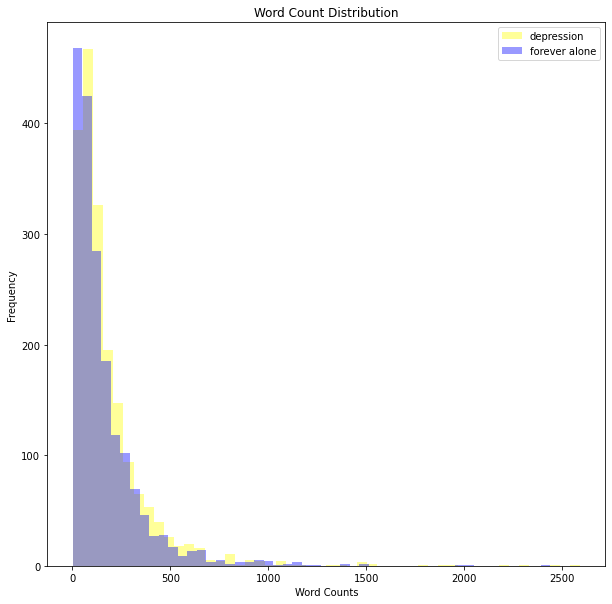

In [27]:
plt.figure(figsize=(10,10))
sns.distplot(depression['word_count'], kde=False, color='yellow', label='depression')
sns.distplot(forever_alone['word_count'], kde=False, color='blue', label='forever alone')
plt.title('Word Count Distribution')
plt.xlabel('Word Counts')
plt.ylabel('Frequency')
plt.legend()

Both subreddits have a positively skewed distribution.

#### Remove Outliers for Word Count

Likewise for word count, i will remove those abnormal posts with word word count of 1 or less.

In [28]:
depression[depression['word_count'] <= 1]

subreddit                                               text  \
1500  depression  httpswwwusatodaycomstorynewshealth20201021seas...   
1581  depression  yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy...   

                                                  title            author  \
1500              seasonal depression may hit a new low         mczeisler   
1581  put me out of my fucking miseryyyyyyyyyyyyyyyy...  bingostingopingo   

      text_length  word_count  
1500          110           1  
1581          931           1

In [29]:
forever_alone[forever_alone['word_count'] <= 1]

subreddit                                               text  \
69    foreveralone  ampx200bhttpspreviewreddit7rscc384a5s61pngwidt...   
123   foreveralone         httpsimgurcomaob5bqdehttpsimgurcomahvsxybi   
199   foreveralone                                              title   
210   foreveralone                                              title   
268   foreveralone  ampx200bhttpspreviewreddit38xlc5xxuyl61jpgwidt...   
386   foreveralone  ampx200bhttpspreviewredditv6198xitnhf61jpgwidt...   
482   foreveralone                                           thoughts   
526   foreveralone  ampx200bhttpspreviewreddit1e4w96havyb61jpgwidt...   
906   foreveralone  ampx200bhttpspreviewredditzp2ijzg1bfu51pngwidt...   
1165  foreveralone                         ampx200bvideoxf7p064qv6m51   
1211  foreveralone                                             please   
1442  foreveralone  ampx200bhttpspreviewredditd5r3fxc6ija51pngwidt...   

                                                  title         author  \
69        depression be hitting us up at 2am with a wyd         big_ai   
123   do you think i could be attractive what can i ...    fateboyyanz   
199                              rate me in private dms   wurzelman675   
210                              rate me in private dms   wurzelman675   
268                            me who has 0 followers         gprateek   
386                                         pretty much        marko0m   
482   im not sure if this sub is really for me since...     yaboiesbie   
526   hit a new low point saw this in my fb newsfeed...  the_chillpill   
906   my depression whenever someone tries to assure...      kolesniko   
1165  i have completely fallen in love with colombia...        timo-va   
1211  how do i reduce my sex drive to the point wher...       nefar131   
1442                                            big oof      balstrate   

      text_length  word_count  
69            117           1  
123            42           1  
199             5           1  
210             5           1  
268           119           1  
386           118           1  
482             8           1  
526           119           1  
906           117           1  
1165           26           1  
1211            6           1  
1442          117           1

In [30]:
depression = depression.drop(labels = [1500, 1581], axis=0)
forever_alone = forever_alone.drop(labels = [69, 123, 199, 210, 268, 386, 482, 526, 906, 1165, 1211, 1442], axis=0)

## Pre-Processing

- Tokenizing (TfidfVectorizor)
- Lemmatizing
- Stop word removal

NLTK stands for Natural Language Toolkit. It is a powerful tool complete with different Python modules and libraries to carry out simple to complex natural language processing (NLP)

### Lemmatizing

Lemmatization performs normalization using vocabulary and morphological analysis of words. In another words, it transform words to their actual root. This step helps us to organise our data and counters words with different tenses but have the same root. I chose lemmatization over stemming because of the stemming suffix stripping rule which leaves most words without the last alphabet which can be quite unpleasant.

In [31]:
# Instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()

In [32]:
depression['text'] = depression['text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
forever_alone['text'] = forever_alone['text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

### Stop Word Removal

This step is important as we do not want stop words to influence our model scores have a more accurate execution. I have selected the english stopwords as my default stopwords. By removing low information words from text, we can focus on the important words instead.

In [33]:
stop = stopwords.words("english")

In [34]:
forever_alone['text'] = forever_alone['text'].apply(lambda x: " ".join([item for item in x.split() if item not in stop]))
depression['text'] = depression['text'].apply(lambda x: " ".join([item for item in x.split() if item not in stop]))

## Exploratory Data Analysis

### Filtering out Top Common Words

#### For Depression subreddit

In [35]:
# Define X & Y
X = depression['text']
y = depression['subreddit']

In [36]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents. I tried both count vectorizer and Tfidf vectorizer and the latter produced the better results so i went with the latter. 

In [37]:
# Instantiate TFIDF
tvec = TfidfVectorizer(stop_words='english', min_df=5, max_df=.95)

# Fit and Transform X_train
X_train = tvec.fit_transform(X_train)

In [38]:
X_train.shape

(1279, 2094)

In [39]:
tvec.get_feature_names()[100:110]

['alright',
 'amazing',
 'amp',
 'angel',
 'anger',
 'angry',
 'animal',
 'anime',
 'annoyed',
 'annoying']

In [40]:
# Transform Test Set
X_test = tvec.transform(X_test)

X_test_df = pd.DataFrame(X_test.todense(),
                         columns = tvec.get_feature_names())

Text(0, 0.5, 'Count')

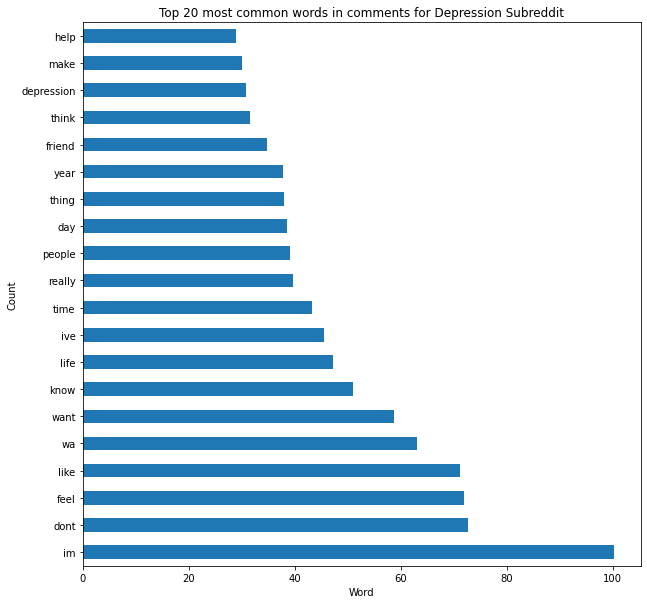

In [41]:
# convert training data to dataframe
X_train_dep = pd.DataFrame(X_train.todense(), 
                          columns=tvec.get_feature_names())

# plot top occuring words
plt.figure(figsize=(10,10))
X_train_dep.sum().sort_values(ascending=False).head(20).plot(kind='barh');
plt.title("Top 20 most common words in comments for Depression Subreddit")
plt.xlabel("Word")
plt.ylabel("Count")

#### For Forever Alone subreddit

In [42]:
# Define X & Y
X = forever_alone['text']
y = forever_alone['subreddit']

In [43]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [44]:
tvec_2 = TfidfVectorizer(stop_words='english', min_df=5, max_df=.95)

In [45]:
X_train = tvec_2.fit_transform(X_train)

In [46]:
# Transform test
X_test = tvec_2.transform(X_test)

X_test_df = pd.DataFrame(X_test.todense(),
                         columns = tvec_2.get_feature_names())

Text(0, 0.5, 'Count')

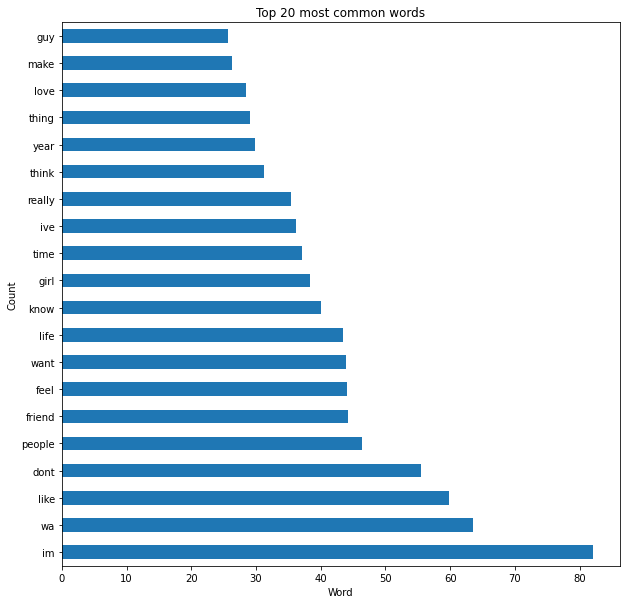

In [47]:
# convert training data to dataframe
X_train_fa = pd.DataFrame(X_train.todense(), 
                          columns=tvec_2.get_feature_names())

# plot top occuring words
plt.figure(figsize=(10,10))
X_train_fa.sum().sort_values(ascending=False).head(20).plot(kind='barh');
plt.title("Top 20 most common words")
plt.xlabel("Word")
plt.ylabel("Count")

As seen from the top 20 words in both subreddits after applying the stop words, there are still many words which have low importance or real meaning to the respective subreddits. Hence, i will extend the stopwords list with my customised stopwords.

### Customising Stop Words

In [48]:
custom_stopwords = ['im', 'like', 'wa', 'dont','feel', 'life', 'time', 'ive', 'really', 'think', 'make', 
                    'people', 'year', 'thing', 'friend', 'day', 'ha', 'way', 'got', 'know', 'want', 
                    'good', 'say', 'word', 'going', 'didnt', 'work', 'thought', 'talk', 'love', 'feeling', 
                    'thats', 'said']

In [49]:
stop.extend(custom_stopwords)

In [50]:
#forever_alone['text'] = forever_alone['text'].apply(lambda x: " ".join([item for item in x.split() if item not in stop]))
depression['text'] = depression['text'].apply(lambda x: " ".join([item for item in x.split() if item not in stop]))

In [51]:
# Define X & Y
X = depression['text']
y = depression['subreddit']

# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# Instantiate CV
tvec = TfidfVectorizer(stop_words='english', min_df=5, max_df=.95)

# Fit and Transform X_train
X_train = tvec.fit_transform(X_train)

In [52]:
# Transform Test Set
X_test = tvec.transform(X_test)

X_test_df = pd.DataFrame(X_test.toarray(),
                         columns = tvec.get_feature_names())

Text(0, 0.5, 'Count')

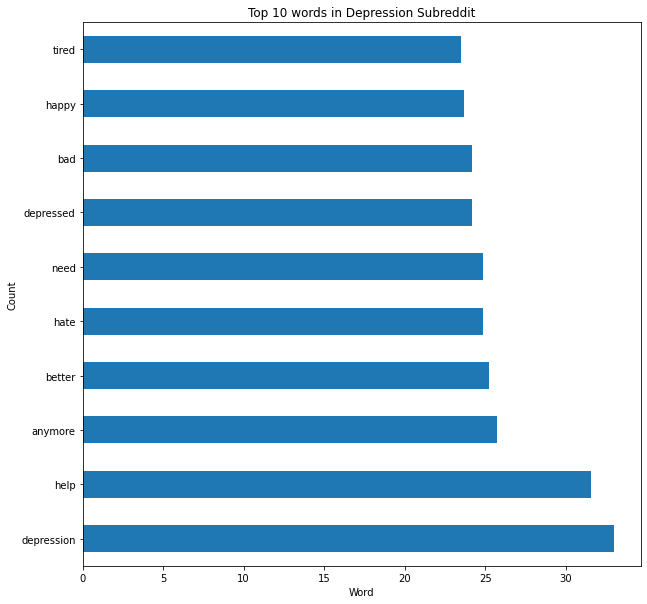

In [53]:
# convert training data to dataframe
X_train_dep = pd.DataFrame(X_train.todense(), 
                          columns=tvec.get_feature_names())

# plot top occuring words
plt.figure(figsize=(10,10))
X_train_dep.sum().sort_values(ascending=False).head(10).plot(kind='barh');
plt.title("Top 10 words in Depression Subreddit")
plt.xlabel("Word")
plt.ylabel("Count")

Doing the same for Forever Alone

In [54]:
forever_alone['text'] = forever_alone['text'].apply(lambda x: " ".join([item for item in x.split() if item not in stop]))
#depression['text'] = depression['text'].apply(lambda x: " ".join([item for item in x.split() if item not in stop]))

In [55]:
# Define X & Y
X = forever_alone['text']
y = forever_alone['subreddit']

# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

tvec_2 = TfidfVectorizer(stop_words='english', min_df=5, max_df=.95)
X_train = tvec_2.fit_transform(X_train)

In [56]:
# Transform test
X_test = tvec_2.transform(X_test)

X_test_df = pd.DataFrame(X_test.todense(),
                         columns = tvec_2.get_feature_names())

Text(0, 0.5, 'Count')

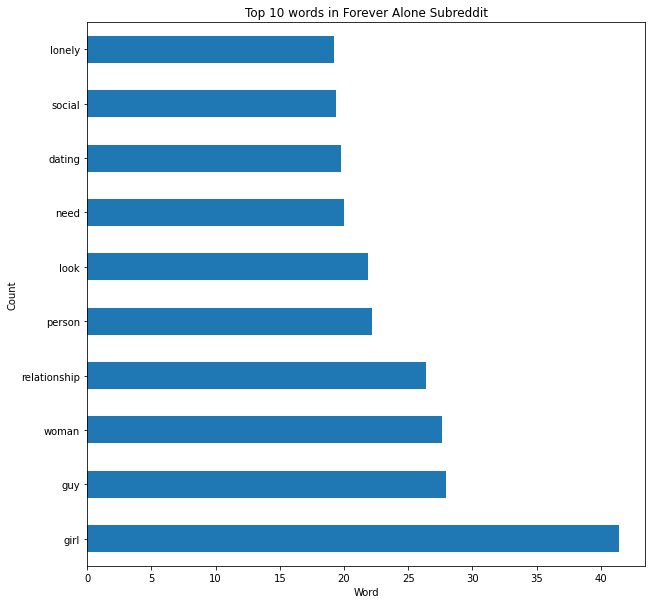

In [57]:
# convert training data to dataframe
X_train_fa = pd.DataFrame(X_train.todense(), 
                          columns=tvec_2.get_feature_names())

# plot top occuring words
plt.figure(figsize=(10,10))
X_train_fa.sum().sort_values(ascending=False).head(10).plot(kind='barh');
plt.title("Top 10 words in Forever Alone Subreddit")
plt.xlabel("Word")
plt.ylabel("Count")

Now the top 10 words looks more meaningful in catergorizing a post.

### Zooming in on more significant words and removing common words in both dataframes

To further explore the meaning of words, i decided to zoom deeper and find words outside the top 50 most common words that are unique to each subreddit

In [58]:
top_fa_words = X_train_fa.sum().sort_values(ascending=False)
top_dep_words = X_train_dep.sum().sort_values(ascending=False)

In [59]:
#top_dep_words.head()

In [60]:
#top_fa_words.head()

In [61]:
dep_filter = [word for word in top_dep_words.index if word not in top_fa_words.index]
fa_filter = [word for word in top_fa_words.index if word not in top_dep_words.index]

In [62]:
#dep_filter

In [63]:
dep_keywords = [word for word in dep_filter if word in top_dep_words]
fa_keywords = [word for word in fa_filter if word in top_fa_words]

In [64]:
dep_keywords_df = pd.DataFrame(dep_keywords, columns=['Depression Key Word'])
#dep_keywords_df

In [65]:
fa_keywords_df = pd.DataFrame(fa_keywords, columns=['Forever Alone Key Word'])
#fa_keywords_df

In [66]:
keywords_total = pd.concat([dep_keywords_df, fa_keywords_df], axis=1)
keywords_total.head(10)

Depression Key Word Forever Alone Key Word
0                 med                     fa
1           diagnosed                 virgin
2      antidepressant                 tinder
3        psychiatrist                   cute
4          depressive              attracted
5           disappear                   kiss
6            disorder                 cuddle
7             cutting                 kissed
8                 mum                   site
9           treatment            introverted

As shown in the top 10 unique words that are not in the top 50 common words between both datasets, it shows a bigger picture. Words like cutting, antidepressant, depressive etc are often associated with depression and its symtoms. Hence these more powerful words can be an indicator of a potentially depressed user.

In [67]:
depression.describe()

text_length   word_count
count   1910.000000  1910.000000
mean     917.105759   181.381675
std     1122.642822   219.717380
min       23.000000     2.000000
25%      308.000000    61.250000
50%      589.500000   118.000000
75%     1134.750000   223.750000
max    12622.000000  2590.000000

In [68]:
forever_alone.describe()

text_length   word_count
count   1834.000000  1834.000000
mean     835.218103   161.769902
std     1036.447656   195.626991
min        7.000000     2.000000
25%      254.000000    50.000000
50%      525.000000   103.000000
75%     1043.750000   203.000000
max    13667.000000  2438.000000

In [69]:
model_df = pd.concat([depression, forever_alone], ignore_index=True)

In [70]:
model_df.isnull().sum()

subreddit      0
text           0
title          0
author         0
text_length    0
word_count     0
dtype: int64

In [71]:
model_df.drop_duplicates(inplace=True)

In [72]:
#model_df.to_csv('./data/model_df.csv', index=False)

# NEXT WORKBOOK --->